### 20 Minutes Data Challenge

### Objective:
- To Predict Quality of Wafer Sensors to indentify Faulty wafers
- A Wafer is a thin slice of semiconductor device which uses in various electronic devices and PV cells. Traditional approach of finding a faulty wafer is to check each wafer manually which are deployed in production line which requires halt on production.
- A Machine Learning model to detect Faulty Wafers based on sensor training data

In [112]:
#Importing necessary packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# pip install -U scikit-learn
#pip install KNNImputer

#pip install kneed
from sklearn.cluster import KMeans
from kneed import KneeLocator

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score
from xgboost import XGBClassifier

### Data Loading

In [113]:
#Loading data using Pandas
df=pd.read_csv("wafer_07012020_041011.csv")
df.head()

,Unnamed: 0,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-501,3076.81,2158.75,2208.2334,1517.0152,1.0980,100,110.1900,0.1247,1.4357,...,64.2405,0.5016,0.0152,0.0040,3.0319,0.0465,0.0299,0.0090,64.2405,-1
1,Wafer-502,2951.62,2511.92,2253.5111,1397.5060,0.9660,100,109.7611,0.1210,1.5527,...,0.0000,0.4953,0.0105,0.0037,2.1266,-0.0012,0.0252,0.0081,0.0000,-1
2,Wafer-503,2930.42,2505.17,2235.0556,1302.6607,1.6347,100,109.9856,0.1230,1.4588,...,NaN,0.4958,0.0111,0.0033,2.2296,-0.0012,0.0252,0.0081,0.0000,-1
3,Wafer-504,2997.28,2357.99,2141.0667,1236.5212,0.9698,100,98.3344,0.1238,1.5973,...,NaN,0.4962,0.0086,0.0024,1.7297,-0.0012,0.0252,0.0081,0.0000,-1
4,Wafer-505,3025.10,2475.18,2235.0556,1302.6607,1.6347,100,109.9856,0.1230,1.5525,...,NaN,0.4983,0.0159,0.0041,3.1927,-0.0012,0.0252,0.0081,0.0000,-1


In [114]:
#Checking information of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 592 entries, Unnamed: 0 to Good/Bad
dtypes: float64(467), int64(124), object(1)
memory usage: 462.6+ KB


In [115]:
#Checking size of data
df.size

59200

In [11]:
##Checking column names
df.columns

Index(['Unnamed: 0', 'Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4',
       'Sensor-5', 'Sensor-6', 'Sensor-7', 'Sensor-8', 'Sensor-9',
       ...
       'Sensor-582', 'Sensor-583', 'Sensor-584', 'Sensor-585', 'Sensor-586',
       'Sensor-587', 'Sensor-588', 'Sensor-589', 'Sensor-590', 'Good/Bad'],
      dtype='object', length=592)

#### Observations
- Data Contains 100 wafers and each wafer with 590 sensor values
- Good/Bad as dependent variable
- Data size of 59.2MB

### Data Exploration

,features,missing_count,missing_count_percentage
0,Sensor-1,1,1.0
1,Sensor-2,1,1.0
2,Sensor-41,2,2.0
3,Sensor-42,2,2.0
4,Sensor-73,79,79.0
...,...,...,...
69,Sensor-570,45,45.0
70,Sensor-579,75,75.0
71,Sensor-580,75,75.0
72,Sensor-581,75,75.0


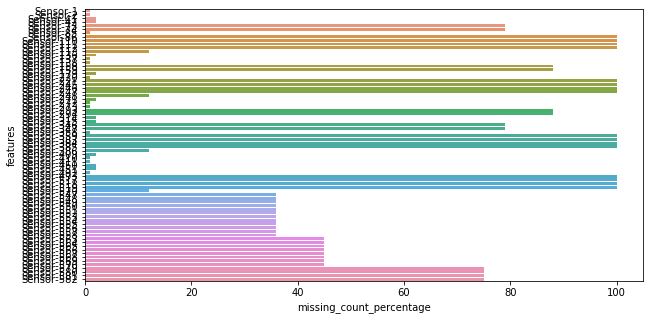

In [22]:
#Exploring missing values
df_missing= df.isnull().sum()[df.isnull().sum() !=0]
df_missing=pd.DataFrame(df_missing.reset_index())
df_missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
df_missing['missing_count_percentage']=((df_missing['missing_count'])/100)*100
plt.figure(figsize=(10,5))
sns.barplot(y=df_missing['features'],x=df_missing['missing_count_percentage'])
df_missing

In [116]:
#Checking description of data
df.describe()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,Sensor-10,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
count,99.000000,99.000000,100.000000,100.000000,100.000000,100.0,100.00000,100.000000,100.000000,100.000000,...,25.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3004.114747,2503.770000,2187.307779,1193.136128,1.196562,100.0,102.52551,0.123413,1.487260,0.000899,...,60.434960,0.500007,0.015468,0.003865,3.091090,0.023001,0.017238,0.005513,57.579040,-0.920000
std,55.844107,83.856839,33.433605,196.895604,0.315792,0.0,4.17551,0.001539,0.060808,0.015851,...,24.306374,0.003733,0.006548,0.001267,1.296146,0.011036,0.005889,0.002113,26.622063,0.393893
min,2890.670000,2158.750000,2113.077800,861.804100,0.802400,100.0,94.12560,0.119300,1.369800,-0.053400,...,0.000000,0.492400,0.006800,0.001700,1.366700,-0.001200,0.007700,0.002100,0.000000,-1.000000
25%,2968.160000,2461.070000,2164.300000,1070.043900,0.879500,100.0,100.36330,0.122150,1.441025,-0.008900,...,42.729400,0.496975,0.011750,0.003175,2.367300,0.018400,0.012700,0.004000,40.253600,-1.000000
50%,2996.160000,2503.860000,2179.077800,1153.896950,1.290600,100.0,102.76885,0.123400,1.482750,-0.000600,...,64.240500,0.500400,0.014150,0.003600,2.814000,0.025200,0.015800,0.005150,65.483100,-1.000000
75%,3042.530000,2562.250000,2216.477800,1302.660700,1.486900,100.0,105.29330,0.124700,1.534825,0.009275,...,76.609400,0.502225,0.017325,0.004125,3.439000,0.033200,0.019000,0.006000,73.865700,-1.000000
max,3158.880000,2698.140000,2253.511100,1820.061300,1.775100,100.0,110.54220,0.126500,1.605300,0.045500,...,108.607600,0.509800,0.046200,0.009900,9.184100,0.049200,0.032600,0.011400,108.607600,1.000000


In [ ]:
#Checking data balances
df['Good/Bad'].value_counts()

#### Observations:
- Name of the wafer doesnot contribute to model training
- Data has severe problem of Missing values
- Graph shows Few columns are completly blank
- Few sensors have zero standard deviation which can inferred as some sensor values are regardless of wafer status good/bad

### Data Preprocessing

In [117]:
#Dropping unnecessary columns
df.drop('Unnamed: 0',axis=1,inplace=True)

#### Missing values

In [55]:
#columns names with missing values more than 70%
columns=df_missing[df_missing['missing_count_percentage']>70]

In [56]:
#Dropping columns
for i in columns.features:
    df.drop(columns=i,inplace=True)

In [57]:
#Checking shape of data
df.shape

(100, 563)

In [58]:
#Missing values Imputation using KNN Imputer
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(df)
data=pd.DataFrame(data=new_array, columns=df.columns)

In [59]:
data.head()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,Sensor-10,...,Sensor-578,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3076.81,2158.75,2208.2334,1517.0152,1.0980,100.0,110.1900,0.1247,1.4357,0.0089,...,9.5549,0.5016,0.0152,0.0040,3.0319,0.0465,0.0299,0.0090,64.2405,-1.0
1,2951.62,2511.92,2253.5111,1397.5060,0.9660,100.0,109.7611,0.1210,1.5527,0.0119,...,11.2721,0.4953,0.0105,0.0037,2.1266,-0.0012,0.0252,0.0081,0.0000,-1.0
2,2930.42,2505.17,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.4588,-0.0143,...,6.6571,0.4958,0.0111,0.0033,2.2296,-0.0012,0.0252,0.0081,0.0000,-1.0
3,2997.28,2357.99,2141.0667,1236.5212,0.9698,100.0,98.3344,0.1238,1.5973,-0.0534,...,19.5919,0.4962,0.0086,0.0024,1.7297,-0.0012,0.0252,0.0081,0.0000,-1.0
4,3025.10,2475.18,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.5525,-0.0078,...,10.8826,0.4983,0.0159,0.0041,3.1927,-0.0012,0.0252,0.0081,0.0000,-1.0


#### Dropping sensor columns

In [ ]:
#dropping sensor columns with zero std
for i in df.columns:
    if df[i].std()==0:
        df.drop(columns=i,inplace=True)
df.shape

In [60]:
#Cheking nulls
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

### Modelling

In [88]:
#dependent and independent variables
x=data.drop(columns='Good/Bad')
y=data['Good/Bad']

In [100]:
#Train_test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25, random_state=42)

In [101]:
#Checking shapes
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((75, 562), (75,), (25, 562), (25,))

In [105]:
#Training and prediction phase
clf = XGBClassifier()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)

In [109]:
#Evaluation
accuracy_score(y_test,y_pred)

0.96